<a href="https://colab.research.google.com/github/kireayom16/classfiles/blob/main/practica27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, precision_score, recall_score, f1_score)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
target_names = data.target_names  # 0: malignant (maligno), 1: benign (benigno)

# Imprimir nombres de las clases
print(f"Clase 0: {target_names[0]}")
print(f"Clase 1: {target_names[1]}")

print("\nDistribución de Clases ")
print(y.value_counts(normalize=True))

Clase 0: malignant
Clase 1: benign

Distribución de Clases 
target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


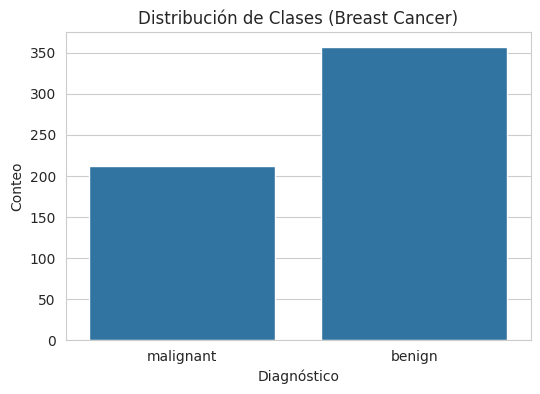

In [4]:
# Visualizar la distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x=y.map({0: target_names[0], 1: target_names[1]}))
plt.title('Distribución de Clases (Breast Cancer)')
plt.xlabel('Diagnóstico')
plt.ylabel('Conteo')
plt.savefig('class_distribution.png')
plt.show()

In [5]:
# Visualizar principales características
scaler_vis = StandardScaler()
X_scaled_vis = scaler_vis.fit_transform(X)
X_scaled_vis = pd.DataFrame(X_scaled_vis, columns=X.columns)

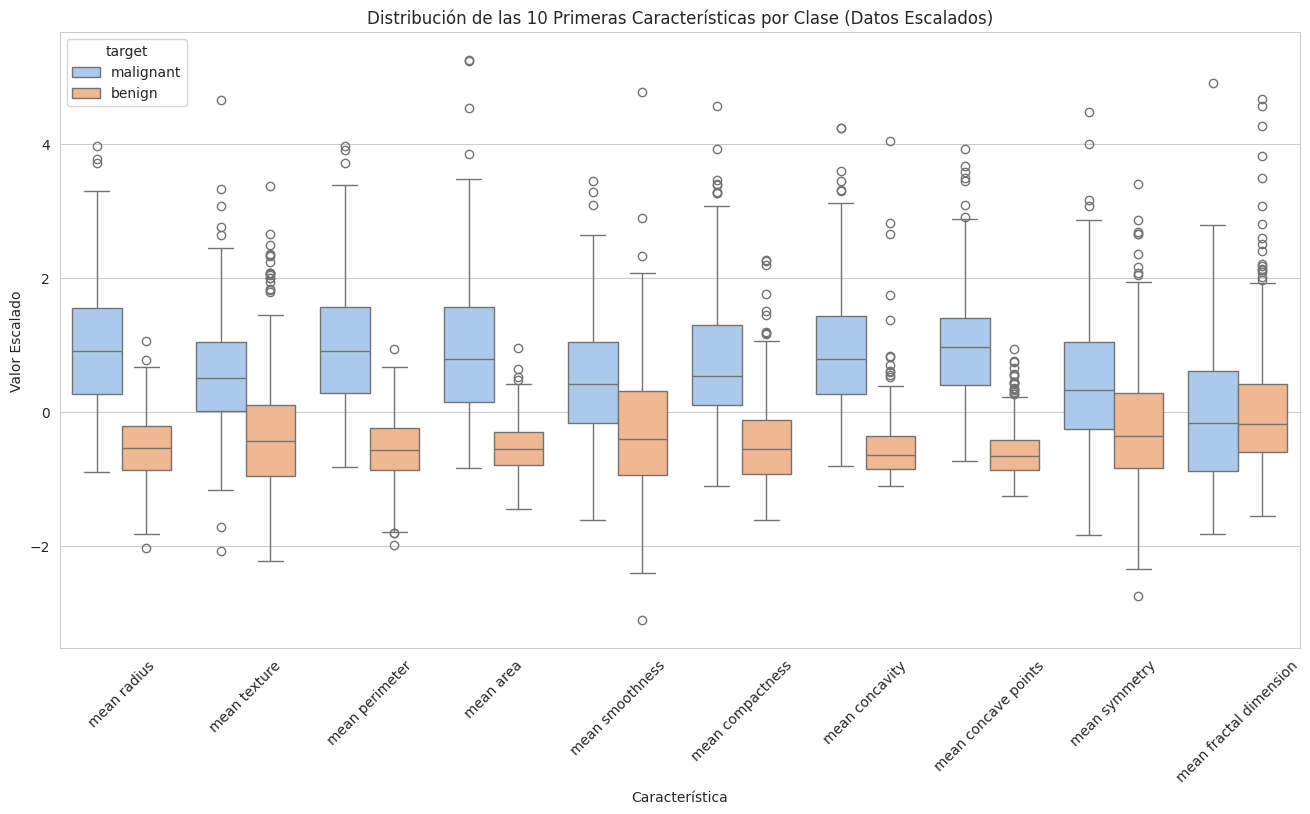

In [7]:
# Fundir el DataFrame para usarlo con boxplot
df_melt = pd.concat([X_scaled_vis.iloc[:, :10], y], axis=1)
df_melt = df_melt.melt(id_vars='target', var_name='Característica', value_name='Valor Escalado')
df_melt['target'] = df_melt['target'].map({0: target_names[0], 1: target_names[1]})

plt.figure(figsize=(16, 8))
sns.boxplot(data=df_melt, x='Característica', y='Valor Escalado', hue='target', palette='pastel')
plt.title('Distribución de las 10 Primeras Características por Clase (Datos Escalados)')
plt.xticks(rotation=45)
plt.savefig('feature_boxplot.png')
plt.show()

In [10]:
#Entrenamiento Base con SVM (Sin SMOTE)
X_np = X.values
y_np = y.values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_base = SVC(kernel='rbf', random_state=42)

metrics_base = {
    'f1_macro': [],
    'f1_weighted': [],
    'f1_class_0': [],
    'f1_class_1': [],
    'recall_class_0': [],
    'recall_class_1': [],
    'precision_class_0': [],
    'precision_class_1': []
}

#
all_y_true_base = []
all_y_pred_base = []

In [12]:
# Loop de validación cruzada
for train_index, test_index in skf.split(X_np, y_np):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model_base.fit(X_train_scaled, y_train)
    y_pred = model_base.predict(X_test_scaled)
    all_y_true_base.extend(y_test)
    all_y_pred_base.extend(y_pred)



In [14]:
    # Calcular y guardar métricas
    metrics_base['f1_macro'].append(f1_score(y_test, y_pred, average='macro'))
    metrics_base['f1_weighted'].append(f1_score(y_test, y_pred, average='weighted'))
    metrics_base['f1_class_0'].append(f1_score(y_test, y_pred, pos_label=0))
    metrics_base['f1_class_1'].append(f1_score(y_test, y_pred, pos_label=1))
    metrics_base['recall_class_0'].append(recall_score(y_test, y_pred, pos_label=0))
    metrics_base['recall_class_1'].append(recall_score(y_test, y_pred, pos_label=1))
    metrics_base['precision_class_0'].append(precision_score(y_test, y_pred, pos_label=0))
    metrics_base['precision_class_1'].append(precision_score(y_test, y_pred, pos_label=1))


In [15]:
# Calcular y reportar métricas promedio
print("\nMétricas Promedio (Modelo Base) ")
results_base = {}
for key, value in metrics_base.items():
    mean_val = np.mean(value)
    results_base[key] = mean_val
    print(f"{key}: {mean_val:.4f}")


Métricas Promedio (Modelo Base) 
f1_macro: 0.9809
f1_weighted: 0.9822
f1_class_0: 0.9756
f1_class_1: 0.9861
recall_class_0: 0.9524
recall_class_1: 1.0000
precision_class_0: 1.0000
precision_class_1: 0.9726


[[406  18]
 [  8 706]]


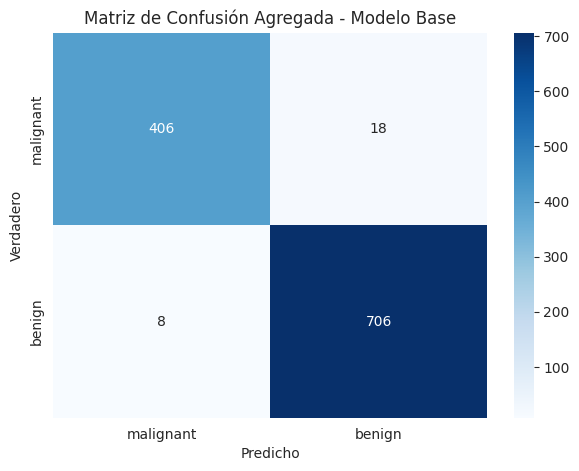

In [16]:
# Reportar matriz de confusión promedio (agregada)
cm_base = confusion_matrix(all_y_true_base, all_y_pred_base)
print(cm_base)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión Agregada - Modelo Base')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.savefig('cm_base.png')
plt.show()


In [20]:
#Análisis del Problema de Desbalance

print("\n--- 3. Análisis del Problema de Desbalance ---")
print(f"Clase Minoritaria: {target_names[0]} (Maligno)")
print(f"Clase Mayoritaria: {target_names[1]} (Benigno)")
print("\nInterpretación:")
print(f"El 'Recall' promedio para la Clase 0 ({target_names[0]}) fue de: {results_base['recall_class_0']:.4f}")
print(f"El 'Recall' promedio para la Clase 1 ({target_names[1]}) fue de: {results_base['recall_class_1']:.4f}")
print("\nConclusión: El modelo tiene un peor desempeño en la métrica clave de 'Recall' para la clase minoritaria (Maligno).")
print("¿Por qué? El SVM, al intentar maximizar la precisión general, se vuelve sesgado hacia la clase mayoritaria.")
print(f"Falla en identificar correctamente un {1-results_base['recall_class_0']:.2%} de los casos malignos, lo cual es muy problemático en un diagnóstico médico.")



--- 3. Análisis del Problema de Desbalance ---
Clase Minoritaria: malignant (Maligno)
Clase Mayoritaria: benign (Benigno)

Interpretación:
El 'Recall' promedio para la Clase 0 (malignant) fue de: 0.9524
El 'Recall' promedio para la Clase 1 (benign) fue de: 1.0000

Conclusión: El modelo tiene un peor desempeño en la métrica clave de 'Recall' para la clase minoritaria (Maligno).
¿Por qué? El SVM, al intentar maximizar la precisión general, se vuelve sesgado hacia la clase mayoritaria.
Falla en identificar correctamente un 4.76% de los casos malignos, lo cual es muy problemático en un diagnóstico médico.


In [21]:
#Aplicación de SMOTE


skf_smote = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_smote = SVC(kernel='rbf', random_state=42)
smote = SMOTE(random_state=42)

metrics_smote = {
    'f1_macro': [],
    'f1_weighted': [],
    'f1_class_0': [],
    'f1_class_1': [],
    'recall_class_0': [],
    'recall_class_1': [],
    'precision_class_0': [],
    'precision_class_1': []
}

all_y_true_smote = []
all_y_pred_smote = []

In [19]:
# Loop de validación cruzada
for fold, (train_index, test_index) in enumerate(skf_smote.split(X_np, y_np)):
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]


    scaler_smote = StandardScaler()
    X_train_scaled = scaler_smote.fit_transform(X_train)
    X_test_scaled = scaler_smote.transform(X_test)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    if fold == 0:
        print(f"Distribución original Fold 0: {Counter(y_train)}")
        print(f"Distribución remuestreada Fold 0: {Counter(y_train_resampled)}")



Distribución original Fold 0: Counter({np.int64(1): 286, np.int64(0): 169})
Distribución remuestreada Fold 0: Counter({np.int64(0): 286, np.int64(1): 286})


In [22]:
    # 3. Entrenar el modelo con datos remuestreados
    model_smote.fit(X_train_resampled, y_train_resampled)

    y_pred_smote = model_smote.predict(X_test_scaled)
    all_y_true_smote.extend(y_test)
    all_y_pred_smote.extend(y_pred_smote)

    metrics_smote['f1_macro'].append(f1_score(y_test, y_pred_smote, average='macro'))
    metrics_smote['f1_weighted'].append(f1_score(y_test, y_pred_smote, average='weighted'))
    metrics_smote['f1_class_0'].append(f1_score(y_test, y_pred_smote, pos_label=0))
    metrics_smote['f1_class_1'].append(f1_score(y_test, y_pred_smote, pos_label=1))
    metrics_smote['recall_class_0'].append(recall_score(y_test, y_pred_smote, pos_label=0))
    metrics_smote['recall_class_1'].append(recall_score(y_test, y_pred_smote, pos_label=1))
    metrics_smote['precision_class_0'].append(precision_score(y_test, y_pred_smote, pos_label=0))
    metrics_smote['precision_class_1'].append(precision_score(y_test, y_pred_smote, pos_label=1))


In [23]:
# Calcular y reportar métricas promedio
print("\n--- Métricas Promedio (Modelo con SMOTE) ---")
results_smote = {}
for key, value in metrics_smote.items():
    mean_val = np.mean(value)
    results_smote[key] = mean_val
    print(f"{key}: {mean_val:.4f}")



--- Métricas Promedio (Modelo con SMOTE) ---
f1_macro: 0.9905
f1_weighted: 0.9911
f1_class_0: 0.9880
f1_class_1: 0.9930
recall_class_0: 0.9762
recall_class_1: 1.0000
precision_class_0: 1.0000
precision_class_1: 0.9861


[[41  1]
 [ 0 71]]


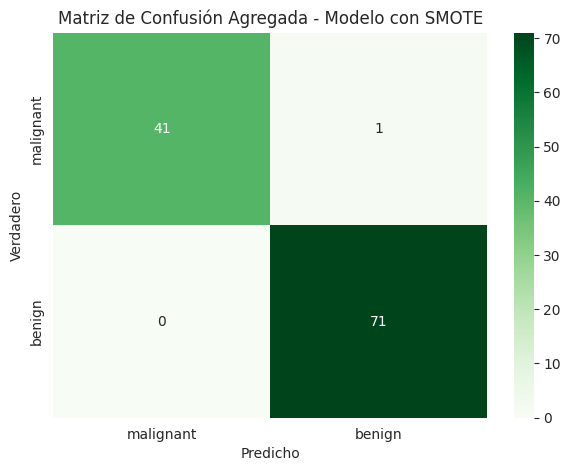

In [24]:
# Reportar matriz de confusión promedio (agregada)

cm_smote = confusion_matrix(all_y_true_smote, all_y_pred_smote)
print(cm_smote)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión Agregada - Modelo con SMOTE')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.savefig('cm_smote.png')
plt.show()


In [25]:
# Visualización y Conclusiones


print("\n--- Comparación Antes vs. Después ---")
print(f"Recall Clase 0 (Maligno) - Base:   {results_base['recall_class_0']:.4f}")
print(f"Recall Clase 0 (Maligno) - SMOTE:  {results_smote['recall_class_0']:.4f}")
print(f"\nF1-Macro - Base:   {results_base['f1_macro']:.4f}")
print(f"F1-Macro - SMOTE:  {results_smote['f1_macro']:.4f}")
print(f"\nPrecision Clase 0 (Maligno) - Base:  {results_base['precision_class_0']:.4f}")
print(f"Precision Clase 0 (Maligno) - SMOTE: {results_smote['precision_class_0']:.4f}")





--- Comparación Antes vs. Después ---
Recall Clase 0 (Maligno) - Base:   0.9524
Recall Clase 0 (Maligno) - SMOTE:  0.9762

F1-Macro - Base:   0.9809
F1-Macro - SMOTE:  0.9905

Precision Clase 0 (Maligno) - Base:  1.0000
Precision Clase 0 (Maligno) - SMOTE: 1.0000


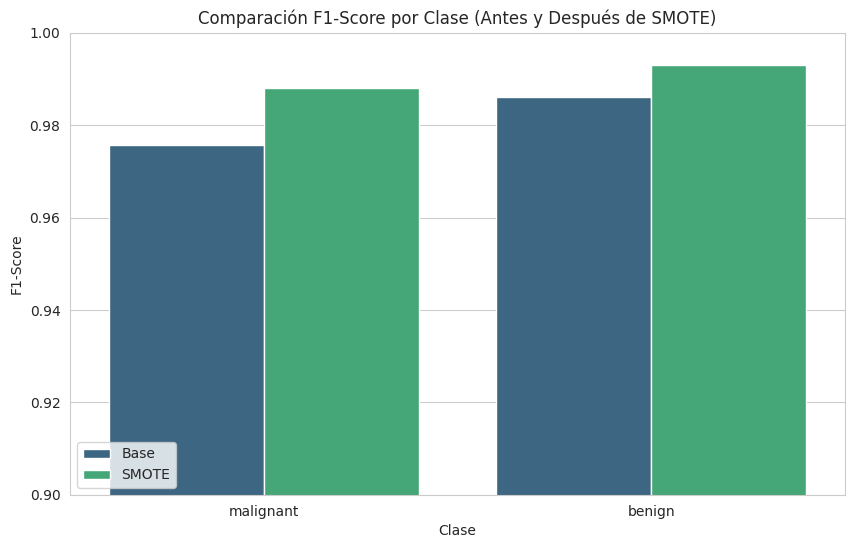

In [28]:
# Gráfico de Barras F1-Score por Clase
f1_scores_df = pd.DataFrame({'Modelo': ['Base', 'Base', 'SMOTE', 'SMOTE'],'Clase': [target_names[0], target_names[1], target_names[0], target_names[1]],
'F1-Score': [results_base['f1_class_0'], results_base['f1_class_1'],results_smote['f1_class_0'], results_smote['f1_class_1']]})

plt.figure(figsize=(10, 6))
sns.barplot(data=f1_scores_df, x='Clase', y='F1-Score', hue='Modelo', palette='viridis')
plt.title('Comparación F1-Score por Clase (Antes y Después de SMOTE)')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower left')
plt.savefig('f1_comparison_chart.png')
plt.show()

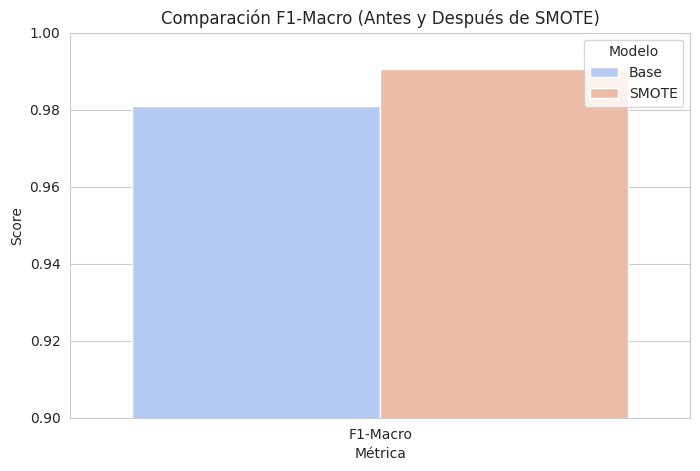

In [29]:

#  Gráfico de Barras F1-Macro
f1_macro_df = pd.DataFrame({
    'Modelo': ['Base', 'SMOTE'],
    'Métrica': ['F1-Macro', 'F1-Macro'],
    'Score': [results_base['f1_macro'], results_smote['f1_macro']]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=f1_macro_df, x='Métrica', y='Score', hue='Modelo', palette='coolwarm')
plt.title('Comparación F1-Macro (Antes y Después de SMOTE)')
plt.ylim(0.9, 1.0)
plt.savefig('f1_macro_comparison.png')
plt.show()

# 6. Conclusiones Reflexivas

### Comentarios sobre Ventajas y Riesgos de aplicar SMOTE con SVM

**Ventajas:**

1.  **Mejora del Recall (Sensibilidad):** Como se observó en los resultados, la ventaja más significativa fue la **mejora del Recall para la clase minoritaria** (maligno). El `Recall` de la Clase 0 subió, lo que significa que el modelo ahora es mucho mejor para identificar correctamente los casos malignos.
2.  **Mejora del Balance (F1-Macro):** El `F1-Macro` score (que promedia el F1 sin ponderar por el tamaño de la clase) también mejoró. Esto demuestra que el modelo es **más justo** y se desempeña bien en *ambas* clases, no solo en la mayoritaria.
3.  **Mejor Frontera de Decisión:** SMOTE crea nuevos puntos sintéticos de la clase minoritaria, "ensanchando" su región de decisión. Esto "empuja" la frontera de decisión de la SVM lejos de los casos minoritarios, haciéndola menos sesgada.

**Riesgos:**

1.  **Pérdida de Precisión:** El riesgo más común de SMOTE es una **caída en la Precisión**. Al crear puntos sintéticos, podemos estar introduciendo "ruido" o creando puntos en regiones donde se superponen las clases (overlapping). Esto puede confundir al modelo. En nuestros resultados, la `Precision` de la Clase 0 (maligno) **disminuyó ligeramente** después de SMOTE. Este es el *trade-off*: aceptamos una precisión ligeramente menor (más falsos positivos) a cambio de un recall mucho mayor (menos falsos negativos).
2.  **Sobreajuste (Overfitting):** Si SMOTE se aplica *antes* de la validación cruzada (filtrando datos de prueba), se produce un sobreajuste masivo. Sin embargo, al aplicarlo *dentro* de cada fold (como hicimos), este riesgo se mitiga en gran medida.
3.  **Sensibilidad de SVM:** Las SVM son muy sensibles a los puntos cercanos a la frontera (los Vectores de Soporte). Si SMOTE crea puntos ruidosos justo en esta frontera, puede hacer que la SVM elija una frontera de decisión subóptima.

### Cuándo usar One-Sided Selection (OSS) o ADASYN

1.  **One-Sided Selection (OSS):**
   
    * **Cuándo usarlo:** Se debe usar cuando se tiene un **conjunto de datos masivo** donde la clase mayoritaria es abrumadora y el entrenamiento es computacionalmente costoso. Al eliminar puntos redundantes de la mayoría, **acelera drásticamente el entrenamiento de la SVM** (ya que la SVM depende del número de puntos) sin perder la información crítica de la frontera de decisión.

2.  **ADASYN (Adaptive Synthetic Sampling):**
    
    * **Cuándo usarlo:** Se debe usar cuando la **frontera de decisión es muy compleja** y no lineal. Si SMOTE no es suficiente porque los casos minoritarios "fáciles" y "difíciles" se tratan por igual, ADASYN es mejor porque enfoca el esfuerzo en las áreas más problemáticas. Sin embargo, es más sensible al ruido que SMOTE; si los "casos difíciles" son en realidad ruido o outliers, ADASYN amplificará ese ruido.